In [60]:
source('../load_environment.R')
options(repr.plot.width=8, repr.plot.height=5)

Pivot Bio, Inc.
This code performs analyses supporting findings of the paper entitled:
"Genetic remodeling of soil diazotrophs enables partial replacement of synthetic nitrogen fertilizer with biological nitrogen fixation in maize".

##------ Mon Aug 19 14:27:42 2024 ------## 
Loaded packages:  tidyverse, readxl, broom, foreach, nlme, lme4, lmerTest, glmmTMB, car, DHARMa, caret, emmeans, multcomp, ggpubr, scales, png, ggthemes and their dependencies.
A complete list of packages used in the analysis is provided in the `packages_citations.txt` file.


## Prepare data

In [61]:
pb <- read.csv("./datasets/pivot_bio_inoculation_rate_trials.csv")

rate_levels <- c("Control","Low","Medium","High")
pb$inoc_rate <- factor(pb$inoc_rate, levels = rate_levels)
pb$n_rate <-  factor(pb$n_rate, levels = c("low","high"), labels = c("LowN","HighN"))
pb$trt <- pb$inoc_rate:pb$n_rate

head(pb)

,trial,rep,plot,n_rate,inoc_rate,d15n_vt_permil,n_uptake_vt_kgha,yield_mgha,trt
,<chr>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,CO01451,1,104,LowN,Control,NA,168.8319,14.13541,Control:LowN
2,CO01451,1,105,LowN,Low,NA,238.4330,13.31575,Low:LowN
3,CO01451,1,108,LowN,High,NA,169.9672,13.49232,High:LowN
4,CO01451,1,109,LowN,Medium,NA,214.2156,14.27615,Medium:LowN
5,CO01451,1,115,HighN,Control,NA,232.1291,14.46162,Control:HighN
6,CO01451,2,201,LowN,Control,NA,202.8855,12.51606,Control:LowN


## Data availability per trial

In [62]:
trial_table <- 
pb %>%
left_join(read.csv("./datasets/pivot_bio_trials_qpcr.csv") %>% transmute(trial,qpcr = 1)) %>%  
gather(variable,value,n_uptake_vt_kgha,yield_mgha,d15n_vt_permil,qpcr) %>%
filter(!is.na(value)) %>% 
dplyr::select(trial,variable) %>% 
distinct() %>% 
mutate(flag = "X", variable = factor(variable,
levels = c("qpcr","d15n_vt_permil","n_uptake_vt_kgha","yield_mgha"),
labels = c("Colonization (QPCR) @ V4-V5","d15N @ VT","N uptake @ VT","Grain Yield @ harvest"))) %>% 
spread(variable,flag) %>% 
mutate_all(function(x) ifelse(is.na(x),"",x))

trial_table

Joining with `by = join_by(trial)`
Warning message in left_join(., read.csv("./datasets/pivot_bio_trials_qpcr.csv") %>% :
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 91 of `x` matches multiple rows in `y`.
i Row 1 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


trial,Colonization (QPCR) @ V4-V5,d15N @ VT,N uptake @ VT,Grain Yield @ harvest
<chr>,<chr>,<chr>,<chr>,<chr>
CO01451,,,X,X
IA01451,,,X,X
IA02451,,X,X,X
IA03451,X,,X,X
IA04451,X,X,X,X
IL01451,X,,X,X
IL03451,X,X,X,X
IN01451,X,,X,X
IN02451,X,,X,X


In [63]:
# Helper function to prettyfy labels 
 
pretty_labels <- function(x, option = 1) {

    if(option == 1){

        out <- factor(x, levels = c("Control:LowN","Low:LowN","Medium:LowN","High:LowN","Control:HighN"),
        labels = c("Uninoculated,\nReduced N fertilizer","Low rate inoculation,\nReduced N fertilizer","Medium rate inoculation,\nReduced N fertilizer","High rate inoculation,\nReduced N fertilizer","Uninoculated,\nBAU N fertilizer"))

    }

    if(option == 2){

        out <- factor(ifelse(grepl("Control",x),"Uninoculated control","PROVEN 40"), levels = c("Uninoculated control","PROVEN 40"))
    
    }

    return(out)

}

## Analysis d15n

In [64]:
# Create weights for sites based on the median 15N natural abundance of the reference plots 
d15n_wts <- pb %>%
filter(trt == "Control:LowN") %>% 
group_by(trial) %>% 
summarise(d15n_wt = median(d15n_vt_permil,na.rm = T)) %>%
mutate(d15n_wt = d15n_wt/sum(d15n_wt,na.rm = T))

Joining with `by = join_by(trial)`


Warning message:
"Removed 79 rows containing missing values (`geom_text()`)."


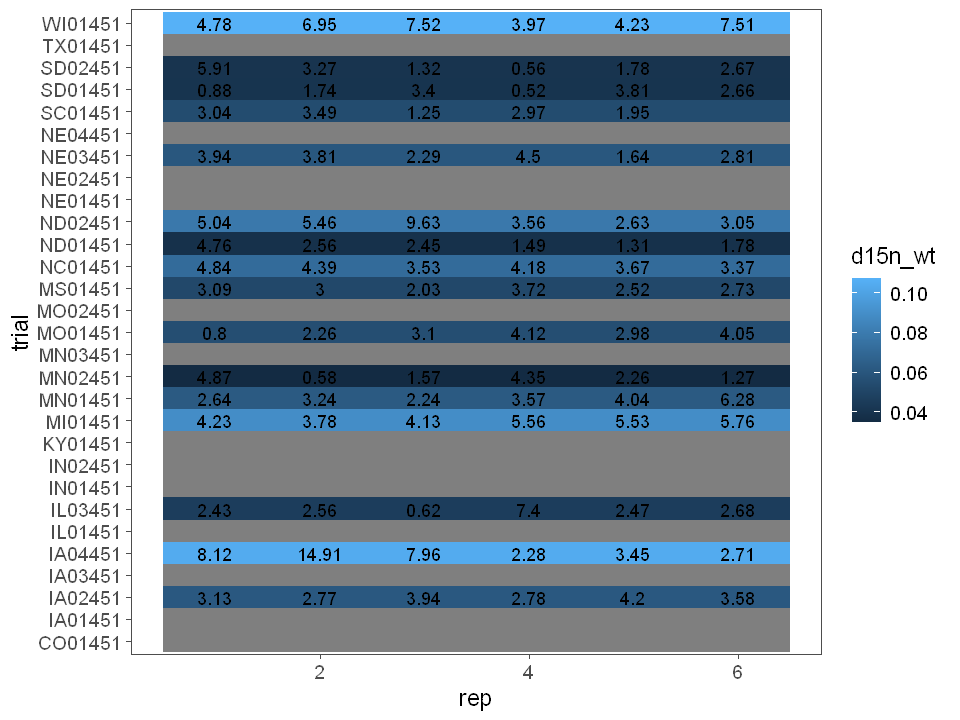

In [65]:
pb <- pb %>% left_join(d15n_wts)

options(repr.plot.width=8, repr.plot.height=6)

pb %>% 
filter(trt == "Control:LowN") %>% 
ggplot(aes(rep,trial)) + 
geom_tile(aes(fill = d15n_wt)) + 
geom_text(aes(label = round(d15n_vt_permil,2)))

[1] 1.74

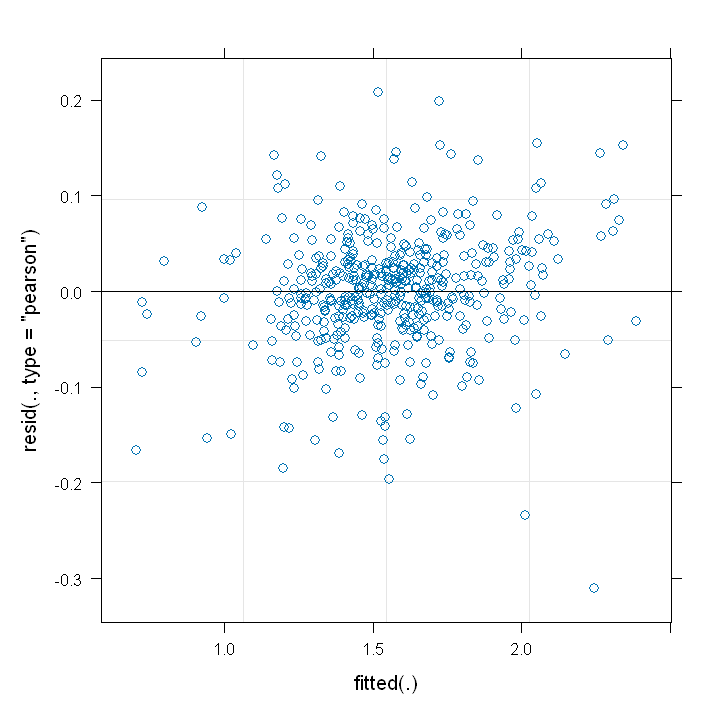

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.97038, p-value = 3.57e-08


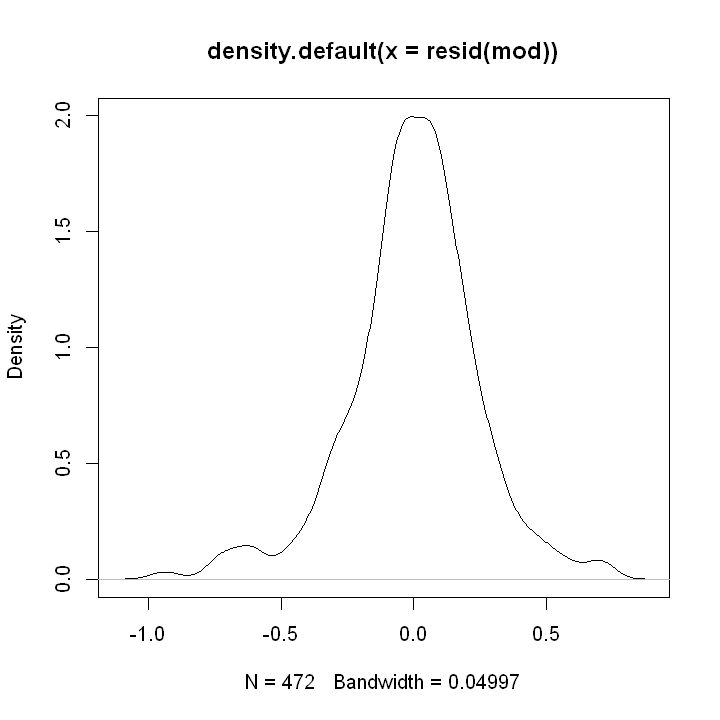

In [66]:
options(repr.plot.width=6, repr.plot.height=6)

# offset constant set so min(y) = 1
(a = 1 - min(pb$d15n_vt_permil, na.rm =  T))

d15n_fit <- lmer(log(d15n_vt_permil + a) ~ trt + (1|trial/rep), weights = d15n_wt, data = pb)
check_assumptions(d15n_fit)

In [67]:
anova(d15n_fit)
summary(d15n_fit)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
trt,0.03190062,0.007975156,4,376.5084,1.791494,0.1298109


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(d15n_vt_permil + a) ~ trt + (1 | trial/rep)
   Data: pb
Weights: d15n_wt

REML criterion at convergence: 290.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6435 -0.4283  0.0324  0.4767  3.1121 

Random effects:
 Groups    Name        Variance Std.Dev.
 rep:trial (Intercept) 0.041004 0.20250 
 trial     (Intercept) 0.044331 0.21055 
 Residual              0.004452 0.06672 
Number of obs: 472, groups:  rep:trial, 95; trial, 16

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)        1.62145    0.06300  20.94170  25.737   <2e-16 ***
trtControl:HighN  -0.09631    0.03902 376.92033  -2.468   0.0140 *  
trtLow:LowN       -0.05752    0.03870 376.23941  -1.487   0.1380    
trtMedium:LowN    -0.07456    0.03870 376.23941  -1.927   0.0548 .  
trtHigh:LowN      -0.07659    0.03870 376.23941  -1.979   0.0485 *  
---
Signif. codes:  0 '

In [68]:
d15n_fit_emm <- emmeans(d15n_fit,  ~ trt,  type = "response")
d15n_fit_emm

 trt           response    SE   df lower.CL upper.CL
 Control:LowN      3.32 0.298 17.4     2.73     3.99
 Control:HighN     2.86 0.271 17.5     2.32     3.46
 Low:LowN          3.04 0.281 17.4     2.48     3.67
 Medium:LowN       2.96 0.277 17.4     2.41     3.58
 High:LowN         2.95 0.276 17.4     2.40     3.57

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 
Intervals are back-transformed from the log(mu + 1.74) scale 

In [69]:
d15n_fit_effects <- data.frame(summary(d15n_fit)$coefficients) %>% 
mutate(trt = gsub("trt","",gsub("\\(Intercept\\)","Control:LowN",row.names(.))))
d15n_fit_effects

,Estimate,Std..Error,df,t.value,Pr...t..,trt
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),1.62145354,0.06300139,20.9417,25.736791,2.475039e-17,Control:LowN
trtControl:HighN,-0.09630501,0.03902454,376.9203,-2.467807,1.403771e-02,Control:HighN
trtLow:LowN,-0.05752476,0.03869716,376.2394,-1.486537,1.379746e-01,Low:LowN
trtMedium:LowN,-0.07456353,0.03869716,376.2394,-1.926848,5.475143e-02,Medium:LowN
trtHigh:LowN,-0.07659392,0.03869716,376.2394,-1.979316,4.850894e-02,High:LowN


Need to back transfrom from the `log(y + a)` scale

In [70]:
d15n_fit_effects_bt <- data.frame(summary(d15n_fit)$coefficients) %>% 
mutate(

    trt = gsub("trt","",gsub("\\(Intercept\\)","Control:LowN",row.names(.))),
    
    # Back trasnform units 
    int = sum((trt == "Control:LowN")*Estimate), # transpose trasnsformed intercept
    margin = Std..Error*qt(0.975,df), #trasnformed margin

    bt_Estimate = ifelse(trt == "Control:LowN",
        exp(Estimate) - a, # Back transform Intercept 
        (exp(int + Estimate)) - (exp(int))),# Back transform Effect
    
    bt_Std..Error = ifelse(trt == "Control:LowN", 
        (exp(Estimate + Std..Error)) - (exp(int)),
        (exp(int + Estimate + Std..Error)) - (exp(int + Estimate))),  
    
    bt_lower.CL = ifelse(trt == "Control:LowN", 
        exp(Estimate - margin) - a,
        (exp(int + Estimate - margin)) - (exp(int))),
    
    bt_upper.CL = ifelse(trt == "Control:LowN", 
        exp(Estimate + margin) - a,
        (exp(int + Estimate + margin)) - (exp(int))),

    # Calculate NDFA
    pNdfa = ifelse(grepl("Control",trt),0,-(bt_Estimate/sum((trt == "Control:LowN")*bt_Estimate))),
    # Estimate error of NDFA
    x1 = sum((trt == "Control:LowN")*bt_Std..Error)/sum((trt == "Control:LowN")*bt_Estimate),
    x2 = bt_Std..Error/bt_Estimate,
    pNdfa_se = pNdfa*sqrt((x1)^2 + (x2)^2), 

    # Make nice labels
    pNdfa_lab = ifelse(grepl("Control",trt) & Pr...t.. < 0.1,"",paste0("Ndfa=",signif(pNdfa*100,3),"%")),
    plab = paste0("p=",signif(Pr...t..,2)),
    mylab = ifelse(trt == "Control:LowN","",ifelse(Pr...t.. > 0.1,plab,paste0(pNdfa_lab,"\n",plab))),
    
    # Units
    yvar = 'delta^"15"*N~at~"VT-R1 (‰)"'

    )

d15n_fit_effects_bt

,Estimate,Std..Error,df,t.value,Pr...t..,trt,int,margin,bt_Estimate,bt_Std..Error,bt_lower.CL,bt_upper.CL,pNdfa,x1,x2,pNdfa_se,pNdfa_lab,plab,mylab,yvar
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
(Intercept),1.62145354,0.06300139,20.9417,25.736791,2.475039e-17,Control:LowN,1.621454,0.13104077,3.3204405,0.3290719,2.6989274,4.028974359,0.00000000,0.0991049,0.0991049,0.00000000,,p=2.5e-17,,"delta^""15""*N~at~""VT-R1 (‰)"""
trtControl:HighN,-0.09630501,0.03902454,376.9203,-2.467807,1.403771e-02,Control:HighN,1.621454,0.07673308,-0.4646144,0.1828955,-0.8040758,-0.098079666,0.00000000,0.0991049,-0.3936501,0.00000000,,p=0.014,p=0.014,"delta^""15""*N~at~""VT-R1 (‰)"""
trtLow:LowN,-0.05752476,0.03869716,376.2394,-1.486537,1.379746e-01,Low:LowN,1.621454,0.07608980,-0.2828861,0.1885015,-0.6329233,0.094824781,0.08519537,0.0991049,-0.6663511,0.05739447,Ndfa=8.52%,p=0.14,p=0.14,"delta^""15""*N~at~""VT-R1 (‰)"""
trtMedium:LowN,-0.07456353,0.03869716,376.2394,-1.926848,5.475143e-02,Medium:LowN,1.621454,0.07608980,-0.3636002,0.1853169,-0.7077237,0.007729528,0.10950360,0.0991049,-0.5096721,0.05685625,Ndfa=11%,p=0.055,Ndfa=11% p=0.055,"delta^""15""*N~at~""VT-R1 (‰)"""
trtHigh:LowN,-0.07659392,0.03869716,376.2394,-1.979316,4.850894e-02,High:LowN,1.621454,0.07608980,-0.3731270,0.1849410,-0.7165525,-0.002550423,0.11237273,0.0991049,-0.4956516,0.05680020,Ndfa=11.2%,p=0.049,Ndfa=11.2% p=0.049,"delta^""15""*N~at~""VT-R1 (‰)"""


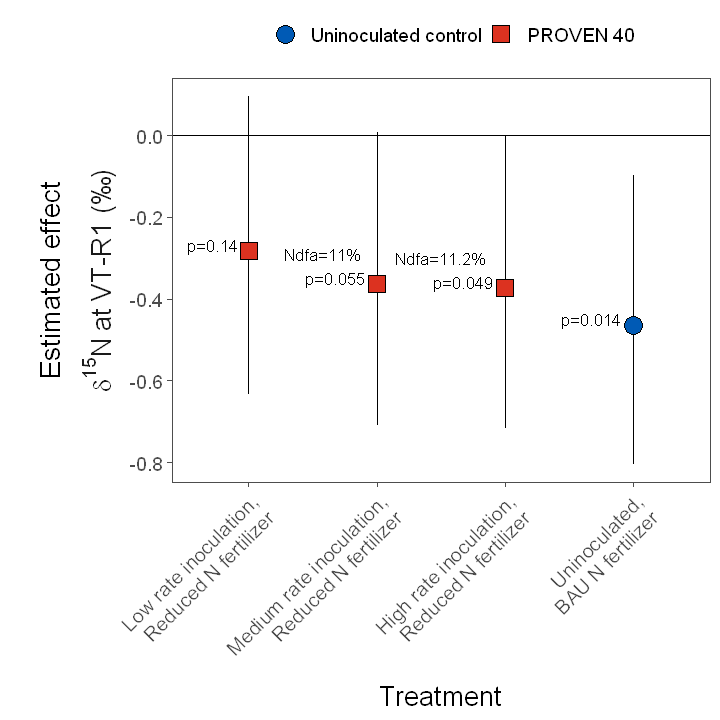

In [71]:
d15n_fit_effects_bt %>% 
filter(trt != "Control:LowN") %>% 
mutate(trt_pretty = pretty_labels(trt), trt_lab = pretty_labels(trt,2)) %>% 
ggplot(aes(x = trt_pretty, y = bt_Estimate)) + 
geom_hline(aes(yintercept  = 0), linetype = 1) + 
geom_errorbar(aes(ymin = bt_lower.CL, ymax = bt_upper.CL), width = 0) + 
geom_point(aes(fill = trt_lab, shape = trt_lab), size = 5) + 
geom_text(aes(label = mylab, y = bt_Estimate), size = 3.5, hjust = 1.2, vjust = 0) + 
labs( y = "\nEstimated effect", x = "Treatment", fill = "", shape = "") + 
scale_fill_manual(values = myColorPalette) + 
scale_shape_manual(values = 21:25) + 
facet_wrap(~yvar, nrow = 2, scales = "free_y",strip.position = "left", labeller = label_parsed) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size = 12), axis.title = element_text(size= 16), strip.placement = "outside", legend.position = "top")


### Analysis of N uptake

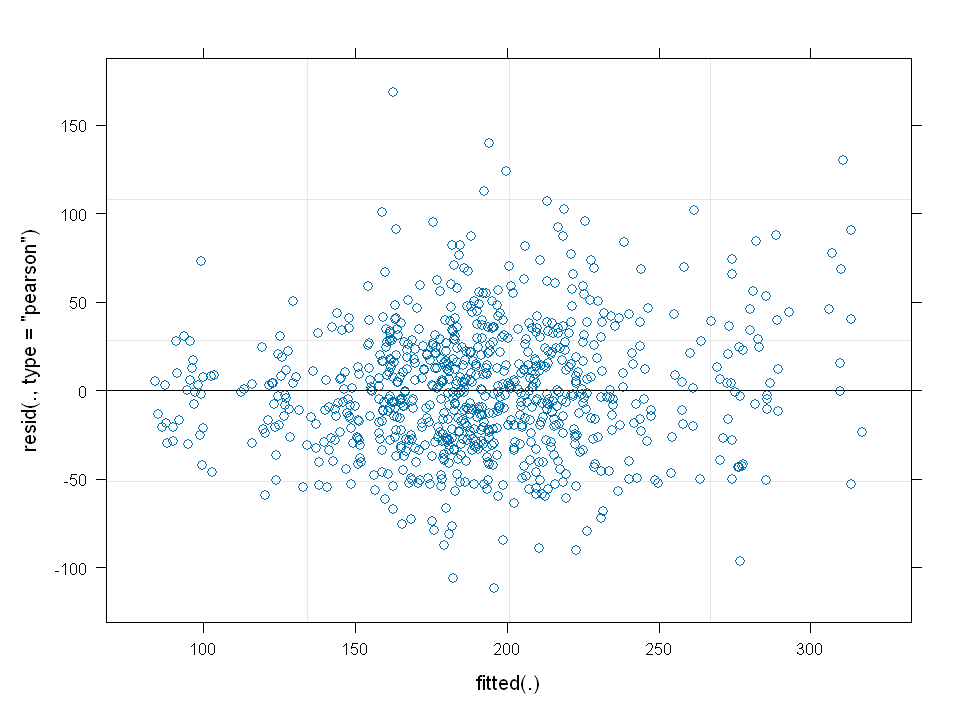

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.98598, p-value = 5.395e-07


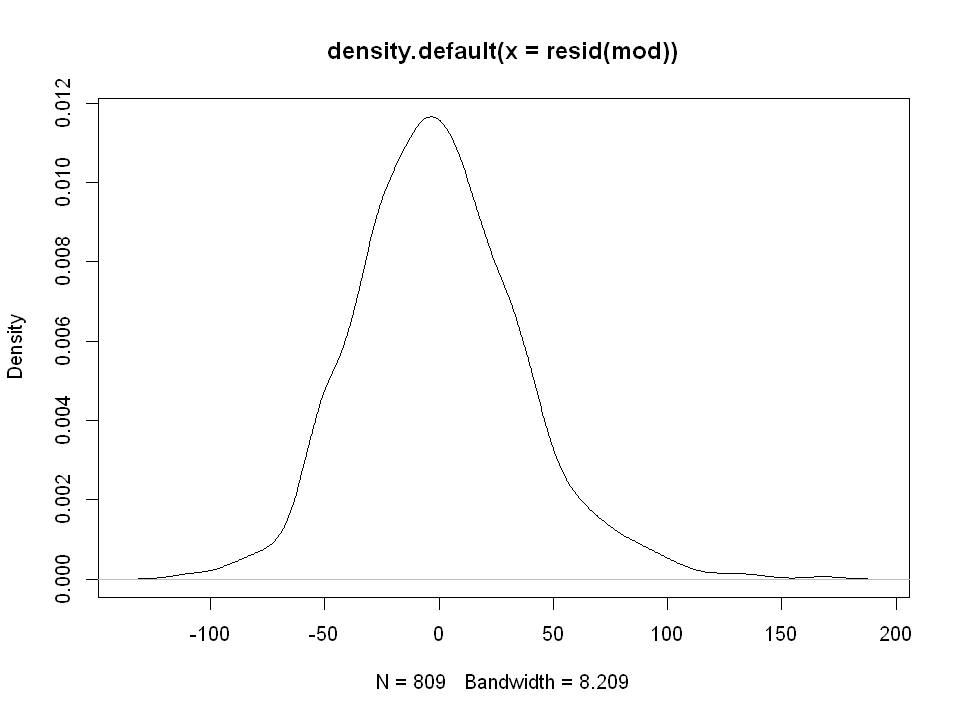

In [72]:
options(repr.plot.width=8, repr.plot.height=6)

nuptake_fit <- lmer(n_uptake_vt_kgha ~ trt + (1|trial/rep), data = pb)
check_assumptions(nuptake_fit)

In [73]:
anova(nuptake_fit)
summary(nuptake_fit)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
trt,4971.685,1242.921,4,642.219,0.8231991,0.510599


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: n_uptake_vt_kgha ~ trt + (1 | trial/rep)
   Data: pb

REML criterion at convergence: 8387.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8668 -0.6389 -0.0505  0.5614  4.3257 

Random effects:
 Groups    Name        Variance Std.Dev.
 rep:trial (Intercept)  344     18.55   
 trial     (Intercept) 1647     40.59   
 Residual              1510     38.86   
Number of obs: 809, groups:  rep:trial, 162; trial, 27

Fixed effects:
                 Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)      191.9119     8.5118  32.2900  22.547   <2e-16 ***
trtControl:HighN   3.3833     4.3174 642.0552   0.784    0.434    
trtLow:LowN       -3.7448     4.3174 642.0552  -0.867    0.386    
trtMedium:LowN    -2.7087     4.3251 642.4657  -0.626    0.531    
trtHigh:LowN      -0.1885     4.3174 642.0552  -0.044    0.965    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 

In [74]:
nuptake_fit_effects <- data.frame(summary(nuptake_fit)$coefficients) %>%
mutate(trt = gsub("trt","",gsub("\\(Intercept\\)","Control:LowN",row.names(.))),
    # Confidence intervals
    lower.CL = Estimate - Std..Error*qt(0.975,df),
    upper.CL = Estimate + Std..Error*qt(0.975,df),
    # Make nice labels
    plab = paste0("p=",signif(Pr...t..,2)),    
    # Units
    yvar = "'Aboveground biomass N at VT-R1 ('*kg~N~ha^-1*')'")

nuptake_fit_effects

,Estimate,Std..Error,df,t.value,Pr...t..,trt,lower.CL,upper.CL,plab,yvar
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
(Intercept),191.9119271,8.511777,32.29001,22.54663392,2.498631e-21,Control:LowN,174.580109,209.243745,p=2.5e-21,'Aboveground biomass N at VT-R1 ('*kg~N~ha^-1*')'
trtControl:HighN,3.3833211,4.317446,642.05517,0.78363954,4.335406e-01,Control:HighN,-5.094699,11.861341,p=0.43,'Aboveground biomass N at VT-R1 ('*kg~N~ha^-1*')'
trtLow:LowN,-3.7447710,4.317446,642.05517,-0.86735801,3.860699e-01,Low:LowN,-12.222791,4.733249,p=0.39,'Aboveground biomass N at VT-R1 ('*kg~N~ha^-1*')'
trtMedium:LowN,-2.7087408,4.325063,642.46575,-0.62628932,5.313476e-01,Medium:LowN,-11.201708,5.784227,p=0.53,'Aboveground biomass N at VT-R1 ('*kg~N~ha^-1*')'
trtHigh:LowN,-0.1885353,4.317446,642.05517,-0.04366824,9.651824e-01,High:LowN,-8.666555,8.289484,p=0.97,'Aboveground biomass N at VT-R1 ('*kg~N~ha^-1*')'


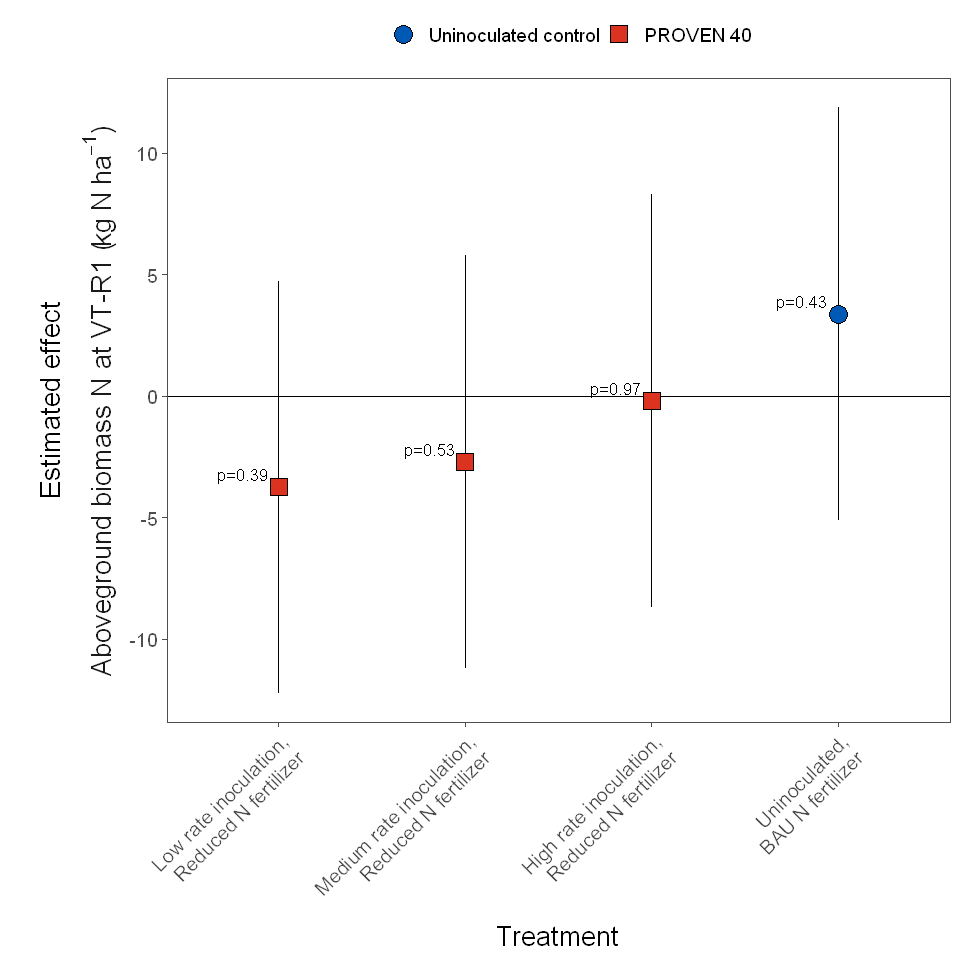

In [75]:
options(repr.plot.width=8, repr.plot.height=8)

nuptake_fit_effects %>% 
filter(trt != "Control:LowN") %>% 
mutate(trt_pretty = pretty_labels(trt), trt_lab = pretty_labels(trt,2)) %>% 
ggplot(aes(x = trt_pretty, y = Estimate)) + 
geom_hline(aes(yintercept  = 0), linetype = 1) + 
geom_errorbar(aes(ymin = lower.CL, ymax = upper.CL), width = 0) + 
geom_point(aes(fill = trt_lab, shape = trt_lab), size = 5) + 
geom_text(aes(label = plab, y = Estimate), size = 3.5, hjust = 1.2, vjust = -0.5) + 
labs( y = "\nEstimated effect", x = "Treatment", fill = "", shape = "") + 
scale_fill_manual(values = myColorPalette) + 
scale_shape_manual(values = 21:25) + 
facet_wrap(~yvar, nrow = 2, scales = "free_y",strip.position = "left", labeller = label_parsed) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size = 12), axis.title = element_text(size= 16), strip.placement = "outside", legend.position = "top")


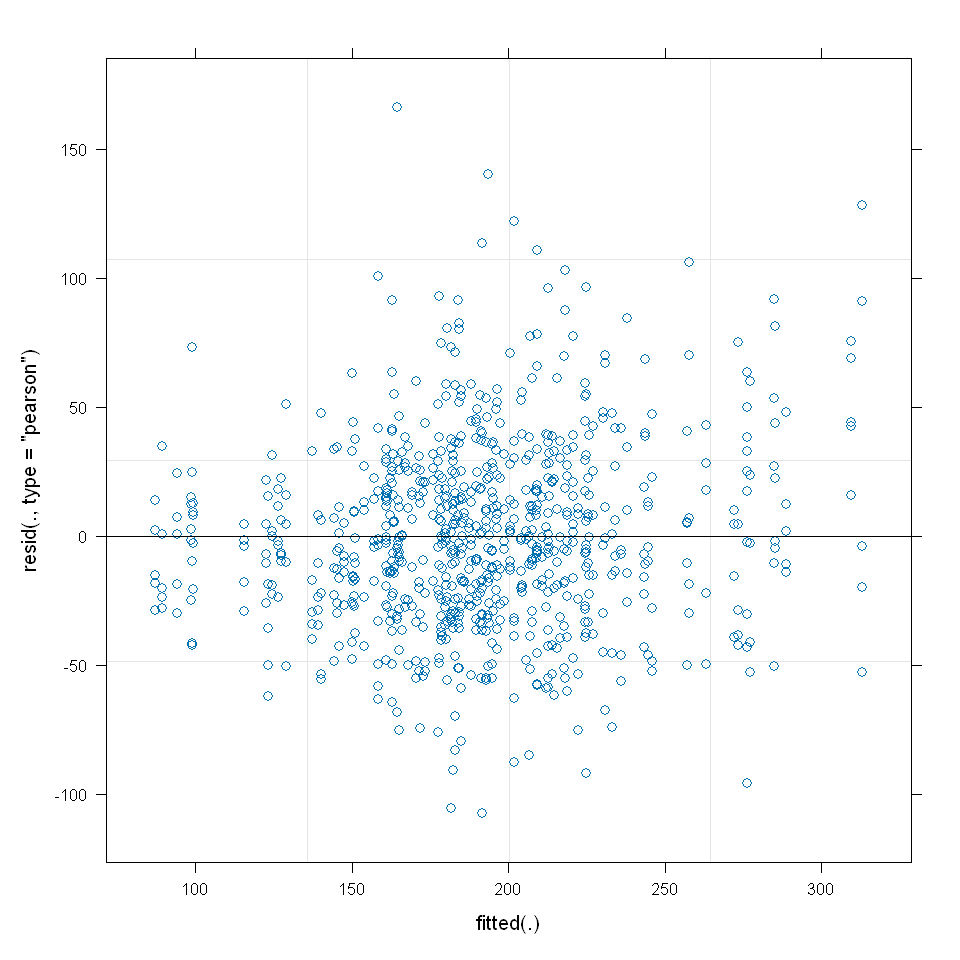

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.98551, p-value = 3.573e-07


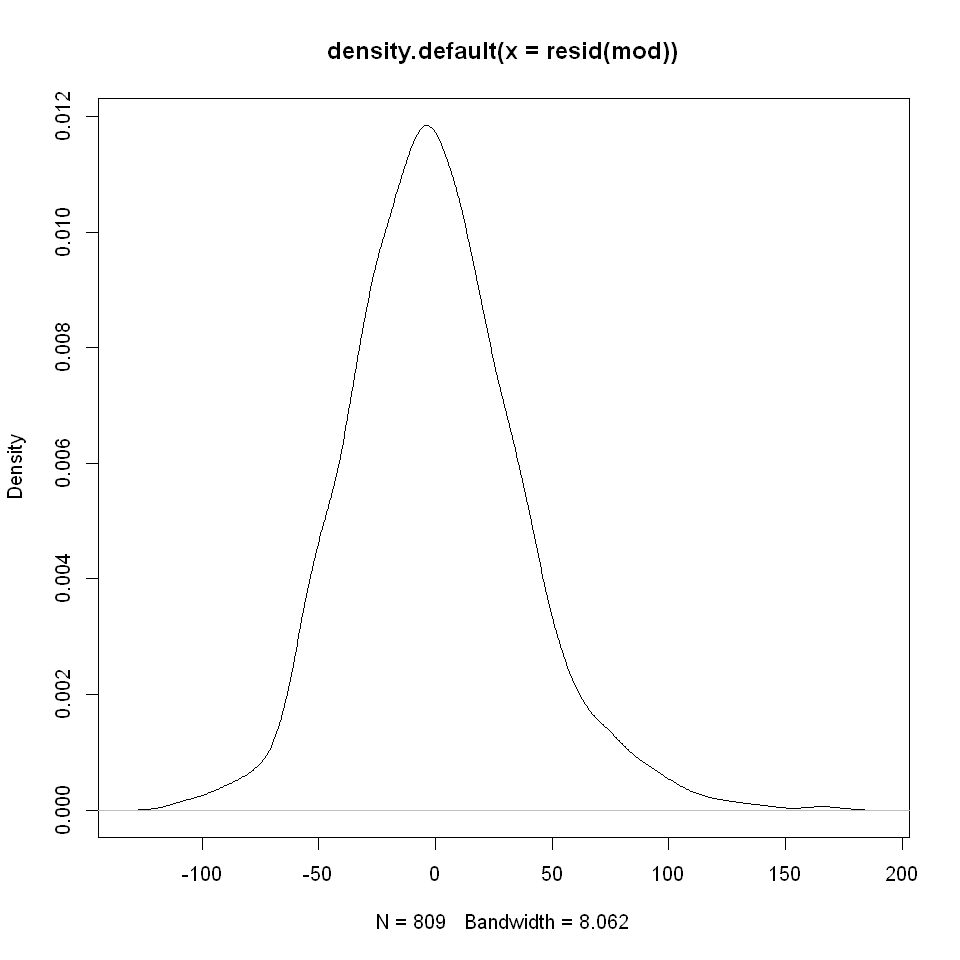

In [76]:
nuptake0_fit <- lmer(n_uptake_vt_kgha ~ (1|trial/rep), data = pb)
check_assumptions(nuptake0_fit)

In [77]:
Nuptake <- data.frame(summary(nuptake0_fit)$coefficients)
Nuptake

pNdfa <- 
d15n_fit_effects_bt %>% 
filter(Pr...t.. < 0.1,pNdfa_lab != "") %>% 
transmute(Estimate = pNdfa, Std..Error = pNdfa_se) %>%
summarise_all(mean)
pNdfa

# Approximate confidence intervals
pNdfa$Estimate + pNdfa$Std..Error*1.96
pNdfa$Estimate - pNdfa$Std..Error*1.96


,Estimate,Std..Error,df,t.value,Pr...t..
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),191.2631,8.062395,26.00142,23.72287,3.837179e-19


Estimate,Std..Error
<dbl>,<dbl>
0.1109382,0.05682822


[1] 0.2223215

[1] -0.0004451511

In [78]:
(pNdfa_nmass <- pNdfa$Estimate*Nuptake$Estimate)

[1] 21.21838

In [79]:
(pNdfa_nmass_se <- pNdfa_nmass*sqrt((Nuptake$Std..Error/Nuptake$Estimate)^2 + (pNdfa$Std..Error/pNdfa$Estimate)^2))

[1] 10.90588

In [80]:
# Approximate confidence intervals
pNdfa_nmass + pNdfa_nmass_se*1.96
pNdfa_nmass - pNdfa_nmass_se*1.96

[1] 42.59391

[1] -0.1571501

## Analysis: Harvest yields

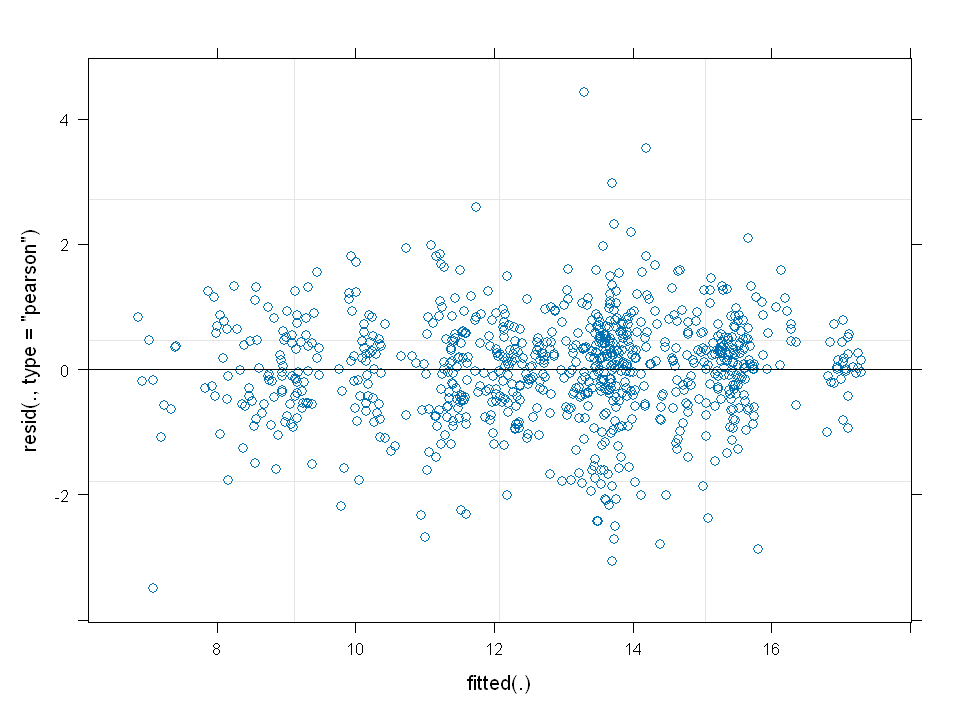

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.97422, p-value = 5.118e-11


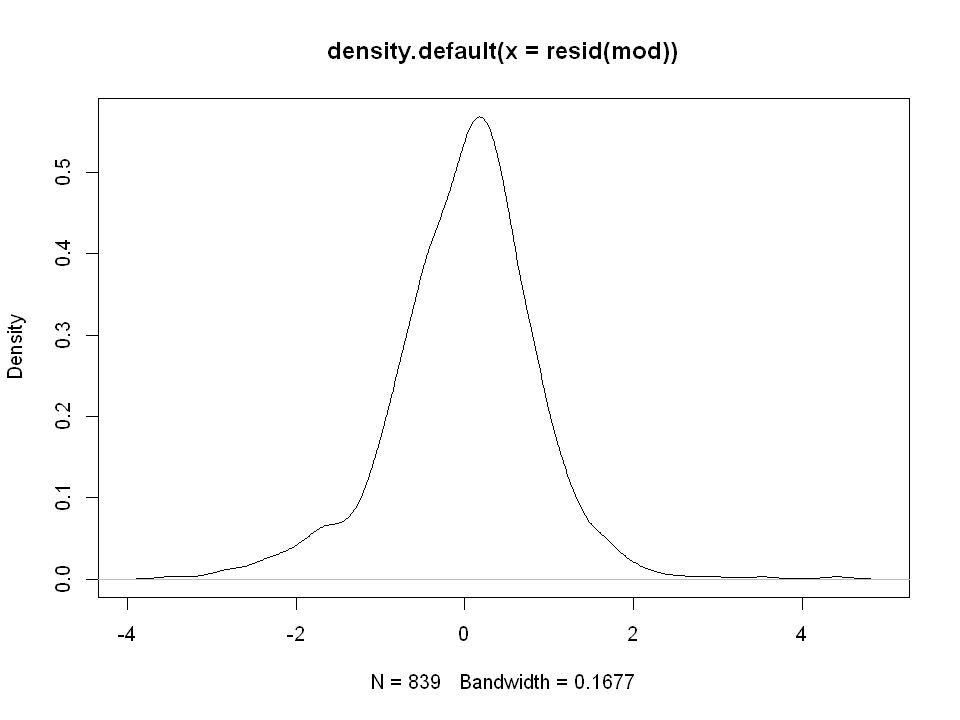

In [81]:
options(repr.plot.width=8, repr.plot.height=6)

yield_fit <- lmer(yield_mgha ~ trt + (1|trial/rep), data = pb)
check_assumptions(yield_fit)

In [82]:
anova(yield_fit)
summary(yield_fit)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
trt,6.230403,1.557601,4,667.206,1.849313,0.1176935


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: yield_mgha ~ trt + (1 | trial/rep)
   Data: pb

REML criterion at convergence: 2527.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7973 -0.5019  0.0676  0.5440  4.8113 

Random effects:
 Groups    Name        Variance Std.Dev.
 rep:trial (Intercept) 0.2799   0.5291  
 trial     (Intercept) 5.2836   2.2986  
 Residual              0.8423   0.9177  
Number of obs: 839, groups:  rep:trial, 168; trial, 28

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       12.73802    0.44202  28.14305  28.818   <2e-16 ***
trtControl:HighN   0.21250    0.10031 667.40884   2.118   0.0345 *  
trtLow:LowN        0.05032    0.10013 667.07146   0.503   0.6155    
trtMedium:LowN     0.14582    0.10013 667.07146   1.456   0.1458    
trtHigh:LowN       0.21360    0.10013 667.07146   2.133   0.0333 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.0

In [83]:
yield_fit_effects <- data.frame(summary(yield_fit)$coefficients) %>%
mutate(trt = gsub("trt","",gsub("\\(Intercept\\)","Control:LowN",row.names(.))),
    
    # Confidence intervals
    lower.CL = Estimate - Std..Error*qt(0.975,df),
    upper.CL = Estimate + Std..Error*qt(0.975,df),

    plab = paste0("p=",signif(Pr...t..,2)),    
    
    # Units
    yvar = "Grain~yields~'('*Mg~ha^-1*')'") 

yield_fit_effects

,Estimate,Std..Error,df,t.value,Pr...t..,trt,lower.CL,upper.CL,plab,yvar
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
(Intercept),12.73802028,0.4420180,28.14305,28.8178776,1.958858e-22,Control:LowN,11.83279477,13.6432458,p=2e-22,Grain~yields~'('*Mg~ha^-1*')'
trtControl:HighN,0.21249504,0.1003079,667.40884,2.1184276,3.450777e-02,Control:HighN,0.01553798,0.4094521,p=0.035,Grain~yields~'('*Mg~ha^-1*')'
trtLow:LowN,0.05032108,0.1001344,667.07146,0.5025354,6.154568e-01,Low:LowN,-0.14629546,0.2469376,p=0.62,Grain~yields~'('*Mg~ha^-1*')'
trtMedium:LowN,0.14582030,0.1001344,667.07146,1.4562459,1.457951e-01,Medium:LowN,-0.05079624,0.3424368,p=0.15,Grain~yields~'('*Mg~ha^-1*')'
trtHigh:LowN,0.21359988,0.1001344,667.07146,2.1331320,3.327824e-02,High:LowN,0.01698334,0.4102164,p=0.033,Grain~yields~'('*Mg~ha^-1*')'


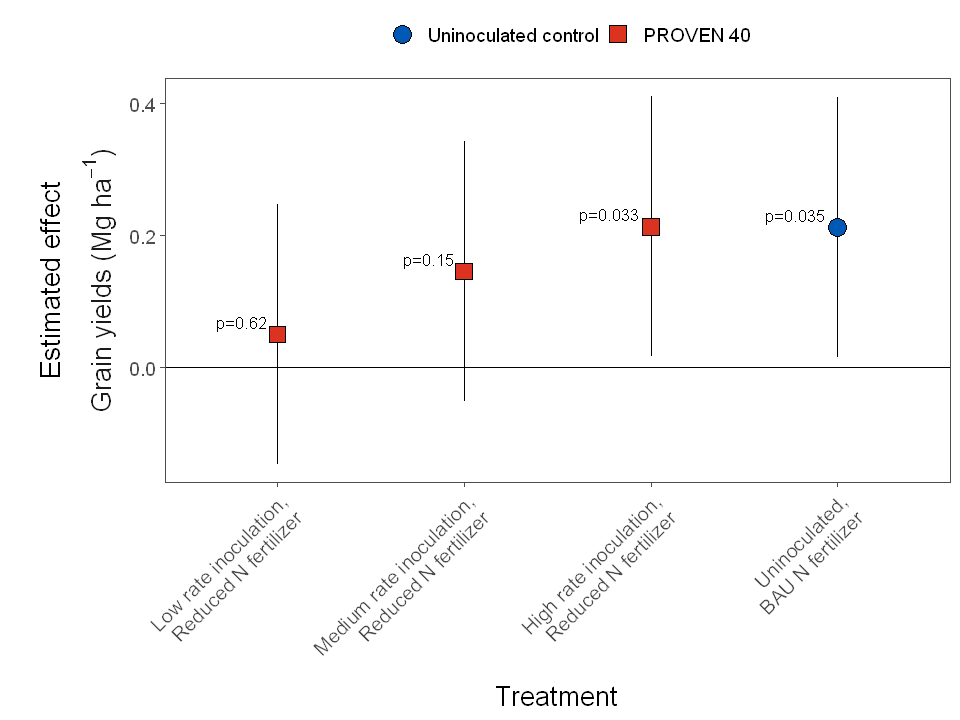

In [84]:
yield_fit_effects %>% 
filter(trt != "Control:LowN") %>% 
mutate(trt_pretty = pretty_labels(trt), trt_lab = pretty_labels(trt,2)) %>% 
ggplot(aes(x = trt_pretty, y = Estimate)) + 
geom_hline(aes(yintercept  = 0), linetype = 1) + 
geom_errorbar(aes(ymin = lower.CL, ymax = upper.CL), width = 0) + 
geom_point(aes(fill = trt_lab, shape = trt_lab), size = 5) + 
geom_text(aes(label = plab, y = Estimate), size = 3.5, hjust = 1.2, vjust = -0.5) + 
labs( y = "\nEstimated effect", x = "Treatment", fill = "", shape = "") + 
scale_fill_manual(values = myColorPalette) + 
scale_shape_manual(values = 21:25) + 
facet_wrap(~yvar, nrow = 2, scales = "free_y",strip.position = "left", labeller = label_parsed) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size = 12), axis.title = element_text(size= 16), strip.placement = "outside", legend.position = "top")

### Final plot

In [85]:
options(repr.plot.width=6, repr.plot.height=8)
plot_b <-d15n_fit_effects_bt[,-1:-2] %>% 
`names<-`(gsub("bt_","",names(.))) %>% 
bind_rows(yield_fit_effects %>% rename(mylab = plab)) %>%
mutate(trt_pretty = pretty_labels(trt), trt_lab = pretty_labels(trt,2)) %>% 
filter(trt != "Control:LowN") %>% 
ggplot(aes(x = trt_pretty, y = Estimate)) + 
geom_hline(aes(yintercept  = 0), linetype = 1) + 
geom_errorbar(aes(ymin = lower.CL, ymax = upper.CL), width = 0) + 
geom_point(aes(fill = trt_lab, shape = trt_lab), size = 4) + 
geom_text(aes(label = mylab, y = Estimate), size = 3.5, hjust = 1, vjust = -0.5) + 
labs( y = "\nEstimated effect", x = "Treatment", fill = "", shape = "") + 
scale_fill_manual(values = myColorPalette) + 
scale_shape_manual(values = 21:25) + 
facet_wrap(~yvar, nrow = 2, scales = "free_y",strip.position = "left", labeller = label_parsed) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size = 12), axis.title = element_text(size= 16), strip.placement = "outside", legend.position = "top")

Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."


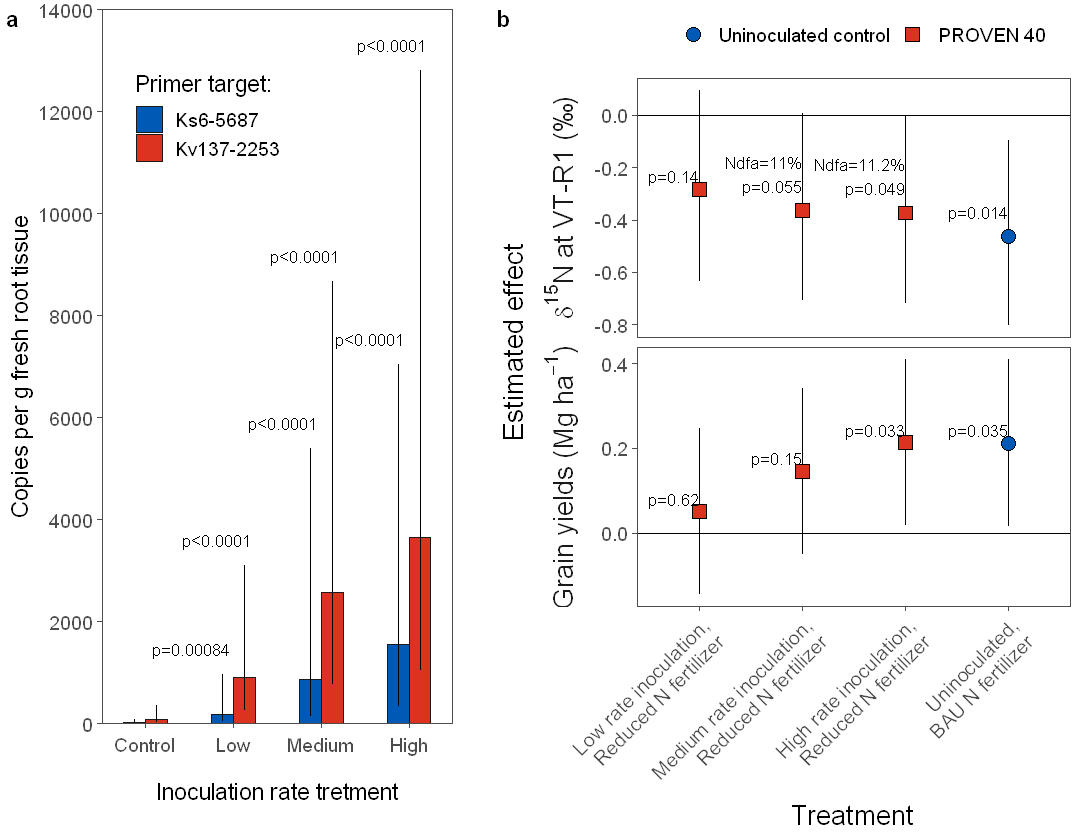

In [86]:
options(repr.plot.width=9, repr.plot.height= 7)
ggarrange(readRDS("./figures/qpcr_plot.rds") + xlab("\nInoculation rate tretment\n"),plot_b, widths = c(3,4),labels = c("a","   b"))
ggsave("./figures/pb_inoc_rate_trials.png",width = 9, height = 7)